<h1 align="center"><b>Traditional Machine Learning - Models</b></h1>
<h3 align="center"><b style="color:gray">Classification of Companies' Economic Activity: A Web Content and Machine Learning-Based Approach</b></h1>

<h3><b>Table of Contents</b></h3>
<ul style = "list-style-type: none; line-height: 0.5em;">
	<li><a href="#data"><h5>1. Data</h5></a></li>
	<li><a href="#preprocess"><h5>2. Embedding Preprocessing</h5></a></li>
	<li><a href="#data-augmentation"><h5>3. Data Augmentation</h5></a></li>
	<li><a href="#baseline"><h5>4. Baseline Model</h5></a></li>
	<li><a href="#design"><h5>5. Experiment Design</h5></a></li>
	<li><a href="#model-preprocessing"><h5>6. Model and Preprocessing Technique</h5></a></li>
    <ul style = "list-style-type: none;">
    	<li><a href="#model"><h5>6.1. Main Model</h5></a></li>
    	<li><a href="#preprocessing"><h5>6.2. Preprocessing Technique (ANOVA)</h5></a></li>
    </ul>
	<li><a href="#models"><h5>7. Models</h5></a></li>
    <ul style = "list-style-type: none;">
    	<li><a href="#models-1"><h5>7.1. Level 1 - Section</h5></a></li>
    	<li><a href="#models-2"><h5>7.2. Level 2 - Division</h5></a></li>
    </ul>
	<li><a href="#final"><h5>8. Final Model</h5></a></li>
    <ul style = "list-style-type: none;">
    	<li><a href="#final-analysis"><h5>8.1. Model Analysis</h5></a></li>
    	<li><a href="#final-cualitative"><h5>8.2. Cualitative Error Analysis</h5></a></li>
    </ul>
	<li><a href="#references"><h5>9. References</h5></a></li>
</ul>


In [5]:
# libraries
import os
import sys
import json
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join("", "../src/")))
from utils.data import Data
from utils.files import load_config
import warnings
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings("ignore") 
# Data Augmentation
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from scipy.spatial.distance import jensenshannon
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Models
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from utils.figures import plot_results_cm, plot_train_test
from models.baseline import MajorityClassifier
from models.hierarchical_level2 import HierarchicalClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

<h2 id="data"><b>1. Data</b></h2>

In [2]:
config = load_config("../config/parameters.yaml")
data = Data(config)

data.random_sample(n = 1, level = [1, 2, 3, 4])

[(array([ 0.02373466,  0.00554702, -0.00095216, ...,  0.00977281,
          0.0223024 ,  0.01156275]),
  ('L', '68', '683', '6831'))]

<h2 id="preprocess"><b>2. Embedding Preprocessing</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
        As explained in the previous section, due to the high dimensionality of the texts, they were processed in chunks. As a result, each company has a different number of embedding vectors. However,for model training, a consistent input size is required, so the embeddings must be preprocessed. The preprocessing techniques should be applied during data loading to avoid loading large volumes of data at once. The preprocessing options include truncating the embeddings or applying pooling, with three available pooling methods: max, mean, and sum. A detailed explanation of these preprocessing techniques is provided in the following table. <a href="#ref-1">[1]</a><a href="#ref-2">[2]</a><a href="#ref-3">[3]</a>
    </p>
</div>

| **Preprocessing Technique** | **Description** | **Operation** |
|----------------------------|----------------|-------------------------|
| **Raw Embedding** | This method keeps the original embedding as is, without applying any transformations or modifications. This is useful when the embeddings already have the correct structure and dimensionality. | $$ X' = X $$ |
| **Truncate** | Reduces the embedding vector to a fixed length by selecting only the first $ k $ dimensions. This is often necessary when working with models that require a fixed input size. | $$ X' = X[:k] $$ |
| **Max Pooling** | Selects the maximum value for each dimension across all feature vectors. This highlights the most important or dominant features in the dataset. | $$ X'_i = \max(X_{1,i}, X_{2,i}, ..., X_{n,i}) $$ |
| **Mean Pooling** | Averages the values for each dimension across all feature vectors. This results in a smoothed representation of the data by reducing variations while maintaining global trends. | $$ X'_i = \frac{1}{n} \sum_{j=1}^{n} X_{j,i} $$ | 
| **Sum Pooling** | Sums the values for each dimension across all feature vectors. This method retains the total magnitude of feature contributions, emphasizing the cumulative effect of individual components. | $$ X'_i = \sum_{j=1}^{n} X_{j,i} $$ | 

<h2 id="data-augmentation"><b>3. Data Augmentation</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
        As identified during the exploratory data analysis, the number of companies—and consequently, the number of samples—per category is unbalanced. To address this issue, three different data augmentation techniques will be implemented, each of which is described in the following table. The purpose of this process is to select which of them will be used to generate a training dataset. The goal of this process is to determine which data augmentation technique is most effective for generating a balanced training dataset. This dataset should contain an equal number of samples for each category, thereby reducing class imbalance and minimizing potential biases in the model's learning process. <a href="#ref-3">[4]</a>
    </p>
    <p style="text-align: justify;">
        Therefore, the objective is to identify the technique that best preserves the original data distribution without simply duplicating existing samples. To assess this, the Jensen-Shannon divergence (JSD) is used. The JSD is a symmetric measure based on the Kullback-Leibler (KL) divergence that quantifies the similarity between two probability distributions. It ranges from 0 to 1, where a value of 0 indicates that the distributions are identical, and higher values suggest greater divergence.<a href="#ref-4">[5]</a> In this context, a lower JSD value indicates that the augmented data closely follows the original distribution, while higher values suggest significant deviations.
    </p>
</div>

| **Augmentation Technique** | **Description** | **Key Aspect** |  
|----------------------------|-----------------|----------------|  
| **SMOTE** | Synthetic Minority Over-sampling Technique (SMOTE) generates synthetic samples by interpolating between an existing minority class instance and its nearest neighbors. | Ensures a more balanced dataset without simply duplicating instances. However, it does not consider the distribution of the majority class, which can lead to overlapping regions.|  
| **ADASYN** | Adaptive Synthetic Sampling (ADASYN) extends SMOTE by focusing on minority class instances that are harder to classify (i.e., near the decision boundary). It assigns more weight to samples that have a higher proportion of majority class neighbors, generating more synthetic examples in these areas. | Increases representation in regions with higher classification difficulty, reducing model bias. |  
| **Borderline-SMOTE** | This SMOTE variant generates synthetic samples only for minority class instances that are close to the decision boundary, identified as those surrounded by majority class samples. The idea is to reinforce the separation between classes by focusing augmentation efforts where misclassification is more likely. | Enhances the model’s ability to distinguish between classes by focusing augmentation on critical areas. |


In [3]:
temp_data, _ = data.load_training_test_data(1, 1000, 0.01, discard = ["T", "O", "U"], preprocess = "truncate")
X, y = temp_data

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

borderline_smote = BorderlineSMOTE(kind="borderline-2")
X_borderline, y_borderline = borderline_smote.fit_resample(X, y)

Categories T, O, U have been skipped.
16196 companies has been loaded for training and 170 companies for testing, spanning 18 categories.


In [4]:
def jensen_shannon_divergence(X_original: list[list[float]], y_original: list[str], 
                              X_augmented: list[list[float]], y_augmented: list[str]) -> float:
    # Normalize data
    scaler = StandardScaler()
    X_original = scaler.fit_transform(X_original)
    X_augmented = scaler.transform(X_augmented)
    # Reduce dimensionality
    pca = PCA(n_components=1)
    X_original_1D = pca.fit_transform(X_original).flatten()
    X_augmented_1D = pca.transform(X_augmented).flatten()
    classes = sorted(set(y_original))
    js_values = []
    # Calculate the value for each class
    for cls in classes:
        X_orig_cls = X_original_1D[np.array(y_original) == cls]
        X_aug_cls = X_augmented_1D[np.array(y_augmented) == cls]
        hist_orig, _ = np.histogram(X_orig_cls, bins=10, density=True)
        hist_aug, _ = np.histogram(X_aug_cls, bins=10, density=True)
        # Add 1e-10 to avoid 0
        hist_orig += 1e-10
        hist_aug += 1e-10
        js_div = jensenshannon(hist_orig, hist_aug)
        js_values.append(js_div)
    avg_js_div = np.nanmean(js_values)
    return avg_js_div

js_smote = jensen_shannon_divergence(X, y, X_smote, y_smote)
js_adasyn = jensen_shannon_divergence(X, y, X_adasyn, y_adasyn)
js_borderline = jensen_shannon_divergence(X, y, X_borderline, y_borderline)
print(f"SMOTE - Average JS Divergence: {js_smote:.4f}")
print(f"ADASYN - Average JS Divergence: {js_adasyn:.4f}")
print(f"Borderline SMOTE - Average JS Divergence: {js_borderline:.4f}")

SMOTE - Average JS Divergence: 0.0118
ADASYN - Average JS Divergence: 0.0150
Borderline SMOTE - Average JS Divergence: 0.0149


<div style="margin: 1em;">
    <p style="text-align: justify;">
        As can be observed, the average Jensen Shannon Divergence of each class is generally lower, meaning that all the three techniques effectively preserve the original data distribution in each category. However, SMOTE performs best, achiving an average JSD of $0.0118$. Thus, it will be chosen as the data augmentation technique for training the model.
    </p>
</div>

<h2 id="baseline"><b>4. Baseline Model</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
        To evaluate the performance of the models in this experiment, we establish a baseline for comparison. The chosen baseline model is a majority class classifier, which assigns every instance to the most frequently occurring class in the dataset. This approach provides a simple yet effective benchmark, allowing us to assess whether more complex models offer a meaningful improvement over naive classification.<br>
        By comparing the performance of our models against this baseline, we can determine whether they capture relevant patterns in the data or merely reflect the inherent class distribution.
    </p>
</div>

In [5]:
maj_class = MajorityClassifier()

X_train, y_train = ([np.random.rand(10) for _ in range(100)], 
                   [np.random.choice(["A", "B", "C"]) for _ in range(100)])
X_test, y_test = ([np.random.rand(10) for _ in range(30)],
                   [np.random.choice(["A", "B", "C"]) for _ in range(30)])

maj_class.fit(X_train, y_train)
predictions = maj_class.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        12
           B       0.00      0.00      0.00         8
           C       0.33      1.00      0.50        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



<h2 id="design"><b>5. Experiment Design</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
        The experimental procedure is structured in two main stages. First, an initial experiment is conducted to determine the most suitable combination of model and preprocessing (aggregation) technique. For this purpose, we focus on the Level 1 classification task of the CNAE hierarchy, using it as a benchmark to compare the performance of different classifiers and vector aggregation methods. Specifically, five widely used models from the literature are trained using four different preprocessing techniques. The combination that achieves the best overall performance—measured primarily by the weighted F1-score—is selected for use in the following stages. 
    </p>
    <p style="text-align: justify;">
        Once selected, a grid search is conducted to optimize the hyperparameters of the chosen model, yielding its most effective configuration (Equation 1). This optimized model is then trained on a larger dataset and stored as the definitive. In this second phase, the focus shifts to the design and optimization of the classification models for Levels 1 and 2. In the case of Level 2 models, we evaluate whether a hierarchical or flat classification approach is more appropriate, given the nature of the CNAE code structure. This ensures that each level of the hierarchy is handled with the most effective strategy.
    </p>
    <p style="text-align: justify;">
        Model performance is primarily evaluated using the weighted F1-score, which appropriately balances performance across classes of varying sizes. Additionally, confusion matrices are analyzed to identify common patterns of misclassification. The standard train-test split used is 80% for training and 20% for testing. In some scenarios, multiple random datasets are employed to ensure robust and statistically reliable results, especially when making key decisions regarding model or strategy selection.
    </p>
</div>

$$
    \text{F1 Generalization Score} = \alpha \cdot F1_{test} - \beta \cdot \frac{|F1_{train} - F1_{test}|}{\sqrt{2}} \qquad\qquad\qquad\qquad (1)
$$
where:

- $\alpha = 0.3$; weights performance over the validation set.
- $\beta = 0.7$; penalizes the degree of overfitting or underfitting with respect to the ideal model.

<h2 id="model-preprocessing"><b>6. Model and Preprocessing Technique</b></h2>

In [6]:
models = [
    ("Baseline", MajorityClassifier()),
    ("RF", RandomForestClassifier(max_depth=10)),
    ("NB", GaussianNB()),
    ("SVM", SVC(kernel="rbf", C=1)),
    ("kNN", KNeighborsClassifier(n_neighbors=7)),
    ("MLP", MLPClassifier(hidden_layer_sizes=(256, 64), activation="relu", solver="adam", max_iter=500)),
]

preprocessings = [
    ("truncate", ""),
    ("pooling", "max"),
    ("pooling", "mean"),
    ("pooling", "sum"),
]

results_summary = {}
f1_data = {}
for preprocess, p_type in preprocessings:
    preprocess_name = f"{p_type.title()} {preprocess.title()}" if p_type else preprocess.title()
    print(f"Evaluating {preprocess_name} preprocessing technique...")
    results_summary[preprocess_name] = {}
    model_scores = {n: [] for n, _ in models}
    f1_data[preprocess_name] = []
    
    # Independent sample
    for i in range(5):
        seed = int(random.random() * 1000)
        train, test = data.load_training_test_data(
            1, 200, 0.2, discard=["T", "O", "U"], seed=seed,
            preprocess=preprocess, type=p_type
        )
        (X_train, y_train), (X_test, y_test) = train, test
        X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)
        
        # Entrenar y evaluar cada modelo
        for model_name, model in models:
            model.fit(X_train_smote, y_train_smote)
            predictions = model.predict(X_test)
            f1 = f1_score(y_true = y_test, y_pred = predictions, average = "weighted")
            model_scores[model_name].append(f1)
            if model_name != "Baseline":
                f1_data[preprocess_name].append(f1)
    
    # Mean and Standard Deviation
    for model_name in model_scores:
        scores = np.array(model_scores[model_name])
        mean = np.mean(scores)
        std = np.std(scores)
        results_summary[preprocess_name][model_name] = f"{mean:.3f} ± {std:.3f}"

Evaluating Truncate preprocessing technique...
Categories T, O, U have been skipped.
3600 companies has been loaded for training and 711 companies for testing, spanning 18 categories.
Categories T, O, U have been skipped.
3600 companies has been loaded for training and 711 companies for testing, spanning 18 categories.
Categories T, O, U have been skipped.
3600 companies has been loaded for training and 711 companies for testing, spanning 18 categories.
Categories T, O, U have been skipped.
3600 companies has been loaded for training and 711 companies for testing, spanning 18 categories.
Categories T, O, U have been skipped.
3600 companies has been loaded for training and 711 companies for testing, spanning 18 categories.
Evaluating Max Pooling preprocessing technique...
Categories T, O, U have been skipped.
3600 companies has been loaded for training and 711 companies for testing, spanning 18 categories.
Categories T, O, U have been skipped.
3600 companies has been loaded for training

<h3 style="margin-left: 1em;" id="model"><b>6.1. Main Model</b></h3>

In [7]:
df_results = pd.DataFrame(results_summary).T
display(df_results)

,Baseline,RF,NB,SVM,kNN,MLP
Truncate,0.001 ± 0.000,0.372 ± 0.020,0.428 ± 0.031,0.524 ± 0.022,0.376 ± 0.013,0.478 ± 0.023
Max Pooling,0.001 ± 0.000,0.426 ± 0.012,0.434 ± 0.024,0.558 ± 0.011,0.448 ± 0.026,0.505 ± 0.009
Mean Pooling,0.001 ± 0.000,0.472 ± 0.018,0.492 ± 0.023,0.582 ± 0.026,0.476 ± 0.026,0.514 ± 0.015
Sum Pooling,0.001 ± 0.000,0.429 ± 0.009,0.098 ± 0.020,0.237 ± 0.030,0.409 ± 0.016,0.517 ± 0.023


<div style="margin-left: 1em;">
    <p style="text-align: justify;">
        From the table above, it can be drawn three conclusions regarding the three main topics of this experiment: (1) whether the models outperform the baseline model, (2) the impact of preprocessing techniques on the performance and which of them has the best results, and (3) which model achieves the highest performance.
    </p>
    <b>1. Comparison with the Baseline Model.</b><br>
    <p style="text-align: justify;">
        The baseline model is a majority classifier, which simply predicts the majority class for every instance. All the models tested in this experiment significantly outperform the baseline model. The performance of the baseline is very low, while all other models show a substantial improvement, demonstrating their ability to better capture the underlying patterns in the data.
    </p>
    <b>2. Impact of Preprocessing on Performance.</b><br>
    <p style="text-align: justify;">
        There is a possible difference in performance between the four preprocessing techniques used in this experiment. Among the five models tested, both max pooling and mean pooling techniques show the best overall performance. However, after further analysis, we opted for mean pooling, as it provides a more reliable performance on the best performing model and all the others.
    </p>
    <b>3. Best Performing Model.</b><br>
    <p style="text-align: justify;">
        The best performing model in this experiment is the SVM in comparation with the other four models. This model achieved higher F1 score on average across the four preprocessing techniques, outperforming the others in terms of balance between precision and recall.
    </p>
    <p style="text-align: justify;">
        A more detailed analysis will follow to select the preprocessing technique with the best performance. In the case of the model no further analysis is necessary because the difference between the performance are high.
    </p>
</div>

<h3 style="margin-left: 1em;" id="preprocess"><b>6.2. Preprocessing Technique (ANOVA)</b></h3>
<div style="margin: 1em;">
    <p style="text-align: justify;">
        The results of the experiment have shown that the preprocessing technique apparently has an impact on model performance. In order to confirm this and rigorously evaluate whether the preprocessing technique significantly influences the model's F1 Score, we will perform an ANOVA test (Analysis of Variance). The ANOVA test relies on important assumptions that must be satisfied for the test to be valid. These assumptions are: (1) the samples are independent, which is true in this case; (2) each sample comes from a normally distributed population, which we will verify using the Shapiro-Wilk test; and (3) the population standard deviations of the groups are equal (homoscedasticity), which we will check using Levene’s test.
        We will set the significance level at 0.05, meaning we accept a 5% risk of rejecting the null hypothesis when it is actually true.
    </p> 
    <p style="text-align: justify;">
        If the ANOVA test indicates that there are significant differences between the preprocessing techniques (i.e., we reject the null hypothesis), we will proceed with a post-hoc analysis using the Tukey HSD (Honestly Significant Difference) test. This test allows us to identify which specific pairs of preprocessing methods differ significantly from each other. The assumptions of the Tukey test are the same as those of ANOVA, and it is only valid when those assumptions are met.
    </p>
    <p style="text-align: justify;">
        The following hypotheses will be tested:
        <ul>
            <li><b>Shapiro-Wilk Test.</b> Normality</li>
            <ul style="list-style-type: none; line-height: 1.5em;">
                <li><b>Null Hypothesis (H<sub>0</sub>)</b>: The data comes from a normal distribution.</li>
                <li><b>Alternative Hypothesis (H<sub>1</sub>)</b>: The data does not come from a normal distribution.</li>
            </ul>
            <li><b>Levene’s Test.</b> Homoscedasticity</li>
            <ul style="list-style-type: none; line-height: 1.5em;">
                <li><b>Null Hypothesis (H<sub>0</sub>)</b>: The variances of the groups are equal (homogeneity of variances).</li>
                <li><b>Alternative Hypothesis (H<sub>1</sub>)</b>: At least one group has a different variance.</li>
            </ul>
            <li><b>ANOVA Test.</b> Comparison of Means</li>
            <ul style="list-style-type: none; line-height: 1.5em;">
                <li><b>Null Hypothesis (H<sub>0</sub>)</b>: There are no significant differences in F1 Score between preprocessing methods.</li>
                <li><b>Alternative Hypothesis (H<sub>1</sub>)</b>: At least one preprocessing method has a significantly different F1 Score.</li>
            </ul>
            <li><b>Tukey HSD Test.</b> Pairwise Comparisons (if ANOVA is significant)</li>
            <ul style="list-style-type: none; line-height: 1.5em;">
                <li><b>Null Hypothesis (H<sub>0</sub>)</b>: The means of the two compared preprocessing techniques are equal.</li>
                <li><b>Alternative Hypothesis (H<sub>1</sub>)</b>: The means of the two compared preprocessing techniques are significantly different.</li>
            </ul>
        </ul>
    </p>
</div>



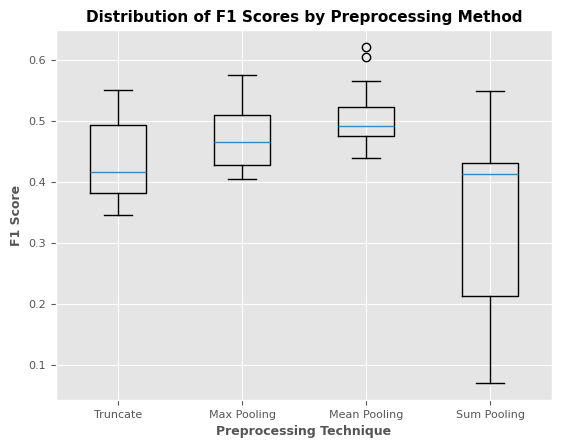


Shapiro-Wilk Test | Normality
 - Truncate:
   + Test Statistic: 0.923
   + p-value: 0.060359
   + Null Hypothesis: Not Rejected
----------------------------------------
 - Max Pooling:
   + Test Statistic: 0.920
   + p-value: 0.051144
   + Null Hypothesis: Not Rejected
----------------------------------------
 - Mean Pooling:
   + Test Statistic: 0.941
   + p-value: 0.160139
   + Null Hypothesis: Not Rejected
----------------------------------------
 - Sum Pooling:
   + Test Statistic: 0.893
   + p-value: 0.013263
   + Null Hypothesis: Rejected
----------------------------------------

Levene Test | Homoscedasticity
 - Test Statistic: 9.698
 - p-value: 0.000012
 - Null Hypothesis: Rejected


In [18]:
# Plot Distribution
fig, ax = plt.subplots(1, 1)
ax.boxplot(f1_data.values())
ax.set_xticklabels(f1_data.keys())
ax.set_ylabel("F1 Score", fontweight ='bold', fontsize=9)
ax.set_xlabel("Preprocessing Technique", fontweight ='bold', fontsize=9)
ax.set_title("Distribution of F1 Scores by Preprocessing Method", fontweight ='bold', fontsize=11)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
plt.show()

alpha = 0.05

# Shapiro-Wilk Test | Normality
print("\n" + "="*40)
print("Shapiro-Wilk Test | Normality")
print("="*40)
for name, values in f1_data.items():
    stat, pvalue = stats.shapiro(values)
    print(f" - {name}:")
    print(f"   + Test Statistic: {stat:.3f}")
    print(f"   + p-value: {pvalue:.6f}")
    print(f"   + Null Hypothesis: {'Rejected' if pvalue < alpha else 'Not Rejected'}")
    print("-" * 40)

# Levene Test | Homoscedasticity
print("\n" + "="*40)
print("Levene Test | Homoscedasticity")
print("="*40)
stat, pvalue = stats.levene(f1_data["Truncate"], f1_data["Max Pooling"], 
                            f1_data["Mean Pooling"], f1_data["Sum Pooling"])
print(f" - Test Statistic: {stat:.3f}")
print(f" - p-value: {pvalue:.6f}")
print(f" - Null Hypothesis: {'Rejected' if pvalue < alpha else 'Not Rejected'}")

<div style="margin-left: 1em;">
    <p style="text-align: justify;">
        As discussed earlier, the validity of the ANOVA test relies on three key assumptions, all of which must be satisfied for the results to be reliable:
    <ol>
        <li>
            <b>Independence Assumption</b>. The independence of the samples is ensured by the way the data was collected, as each F1 score originates from completely independent samples.
        </li>
        <li>
            <b>Normality Assumption</b>. The Shapiro-Wilk test results indicate that all datasets, except <i>Sum Pooling</i>, follow a normal distribution, as their p-values are above the 0.05 significance threshold. Therefore, we fail to reject the null hypothesis of normality for the three methods. This means we can assume that <i>Truncate</i>, <i>Max Pooling</i>, and <i>Mean Pooling</i> follow a normal distribution.
        </li>
        <li>
            <b>Homoscedasticity Assumption</b>. The Levene’s test results show that at least one of the groups has a different variance, meaning that the assumption of homogeneity of variances does not hold.
        </li>
    </ol>
    </p>
    <p style="text-align: justify;">
        Since both normality and homoscedasticity assumptions do not fully hold, we aim to analyze the source of these violations. For this purpose, we will examine the box-and-whisker plot to better understand the distributional characteristics of the preprocessing techniques.
    </p>
    <p style="text-align: justify;">
        As observed, the normality tests suggest that we can assume a normal distribution for the techniques <i>Truncate</i>, <i>Mean Pooling</i>, and <i>Max Pooling</i>. However, the assumption of homoscedasticity is clearly violated. From the boxplot, we can see that the first three techniques share a relatively similar distribution, and we may reasonably assume equal variances among them. In contrast, <i>Sum Pooling</i> appears to be an outlier in this context: it exhibits a much wider variance and includes F1-score values as low as 0.1, which are not present in the other groups. This strongly suggests that <i>Sum Pooling</i> introduces significant heterogeneity into the dataset.
    </p>
    <p style="text-align: justify;">
        Based on these observations, we propose excluding the <i>Sum Pooling</i> technique from the ANOVA test in order to meet the required assumptions. Additionally, the boxplot illustrates the lower robustness and consistency of <i>Sum Pooling</i> compared to the other methods, further supporting its exclusion.
    </p>
    <p style="text-align: justify;">
        We will now repeat Levene’s test to re-evaluate homoscedasticity after removing the <i>Sum Pooling</i> data. If the assumption is satisfied, we will proceed with the ANOVA test again to assess whether significant differences exist among the remaining preprocessing techniques.
    </p>
</div>

In [19]:
f1_data_filtered = f1_data.copy()
f1_data_filtered.pop("Sum Pooling")

# Levene Test | Homoscedasticity
print("\n" + "="*40)
print("Levene Test | Homoscedasticity")
print("="*40)
stat, pvalue = stats.levene(f1_data_filtered["Truncate"], f1_data_filtered["Max Pooling"], 
                            f1_data_filtered["Mean Pooling"])
print(f" - Test Statistic: {stat:.3f}")
print(f" - p-value: {pvalue:.6f}")
print(f" - Null Hypothesis: {'Rejected' if pvalue < alpha else 'Not Rejected'}")

# ANOVA Test
print("\n" + "="*40)
print("ANOVA Test | Mean Comparison")
print("="*40)
stat, pvalue = stats.f_oneway(f1_data_filtered["Truncate"], f1_data_filtered["Max Pooling"], 
                              f1_data_filtered["Mean Pooling"])
print(f" - Test Statistic: {stat:.3f}")
print(f" - p-value: {pvalue:.6f}")
print(f" - Null Hypothesis: {'Rejected' if pvalue < alpha else 'Not Rejected'}")


Levene Test | Homoscedasticity
 - Test Statistic: 2.533
 - p-value: 0.086484
 - Null Hypothesis: Not Rejected

ANOVA Test | Mean Comparison
 - Test Statistic: 10.335
 - p-value: 0.000113
 - Null Hypothesis: Rejected


<div style="margin-left: 1em;">
    <p style="text-align: justify;">
        After removing <i>Sum Pooling</i>, we observe that the assumption of homoscedasticity is now satisfied, as the Levene’s test yields a p-value greater than 0.05. This indicates that the variances among the remaining groups can be considered equal. Furthermore, the ANOVA test reveals that there are statistically significant differences between at least two of the preprocessing methods. Therefore, we proceed to perform a Tukey HSD (Honestly Significant Difference) post-hoc test to identify which specific pairs of groups differ significantly.
    </p>
    <p style="text-align: justify;">
        Although the statistical tests indicate no significant differences between <i>Mean Pooling</i> and <i>Max Pooling</i>, we opt to select <i>Mean Pooling</i> as the preferred aggregation technique. This decision is supported by the observation that, in the case of the SVM classifier—which was selected due to its superior overall performance—<i>Mean Pooling</i> consistently yields higher average F1 scores compared to <i>Max Pooling</i>. Therefore, <i>Mean Pooling</i> is considered the most suitable choice in this context.
</p>
</div>

In [20]:
# Tukey HSD
print("\n" + "="*64)
data = []
groups = []
for name, values in f1_data_filtered.items():
    data.extend(values)
    groups.extend([name] * len(values))

tukey = pairwise_tukeyhsd(endog = data, groups = groups, alpha = alpha)
print(tukey)


      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
 Max Pooling Mean Pooling   0.0331 0.0965 -0.0046  0.0707  False
 Max Pooling     Truncate  -0.0384 0.0447  -0.076 -0.0007   True
Mean Pooling     Truncate  -0.0715 0.0001 -0.1091 -0.0338   True
----------------------------------------------------------------


<div style="margin-left: 1em;">
    <p style="text-align: justify;">
        The results of the Tukey HSD post-hoc test confirm the findings from the ANOVA. Specifically, significant differences in mean F1 scores are observed between <i>Truncate</i> and both <i>Max Pooling</i> and <i>Mean Pooling</i>, as indicated by the rejection of the null hypothesis in these comparisons. However, no statistically significant difference is found between <i>Max Pooling</i> and <i>Mean Pooling</i>, suggesting that these two techniques perform similarly in terms of model performance. These results suggest that while pooling techniques generally outperform the truncation method, there is no clear advantage between the mean and max strategies. However, we will use mean pooling as the main aggregation technique due to its slightly superior mean and better performance on SVM.
    </p>
    <p style="text-align: justify;">
</div>

<h2 id="models"><b>7. Models</b></h2>

<h3 style="margin-left: 1em;" id="models-1"><b>7.1. Level 1 - Sector</b></h3>
<div style="margin-left: 2em;">
    <p style="text-align: justify;">
    </p>
</div>

<h4 style="margin-left: 1.5em;"><b>Hyperparameter Optimization</b></h4>

In [ ]:
grid = []
for C in [0.1, 1, 10, 100]:
    grid.append({"C": C, "kernel": "linear"})
for C in [0.1, 1, 10, 100]:
    for gamma in ["scale", "auto", 0.1, 1]:
        grid.append({"C": C, "kernel": "rbf", "gamma": gamma})
for C in [0.1, 1, 10, 100]:
    for gamma in ["scale", "auto", 0.1, 1]:
        for coef0 in [0.0, 0.5, 1.0, 2.0]:
            grid.append({"C": C, "kernel": "poly", "gamma": gamma, "coef0": coef0})

# Load previous results if the file already exists
SAVE_PATH = "results/seccion.json"

if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        incremental_results = json.load(f)
    print(f"Loaded {len(incremental_results)} previous results from '{SAVE_PATH}'.")
else:
    incremental_results = []

smote = SMOTE()
datasets = []
for _ in tqdm(range(5), desc = "Datasets loading"):
    seed = int(random.random() * 100)
    train, test = data.load_training_test_data(1, 200, 0.2, discard = ["T", "O", "U"], seed = seed, 
                                               preprocess = "pooling", type = "mean", verbose = False)
    (X_train, y_train), (X_test, y_test) = train, test
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    datasets.append((X_train_smote, y_train_smote, X_test, y_test))

evaluated_indices = {json.dumps(entry["params"], sort_keys = True) for entry in incremental_results}
train_results = []
test_results = []

for params in tqdm(grid, desc = "Training models"):
    params_key = json.dumps(params, sort_keys = True)
    if params_key in evaluated_indices:
        continue  # Already evaluated

    f1_train_lst = []
    f1_test_lst = []
    for X_train, y_train, X_test, y_test in datasets:
        model = SVC(**params)
        model.fit(X_train, y_train)
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        train_value = f1_score(y_true = y_train, y_pred = train_predictions, average = "weighted")
        test_value = f1_score( y_true = y_test,  y_pred = test_predictions,  average = "weighted")
        f1_train_lst.append(train_value)
        f1_test_lst.append(test_value)
    train_mean = np.mean(f1_train_lst)
    test_mean = np.mean(f1_test_lst)
    incremental_results.append({
        "params": params,
        "train": train_mean,
        "test": test_mean
    })

    # Incremental saving
    with open(SAVE_PATH, "w") as f:
        json.dump(incremental_results, f, indent = 4)

Loaded 2 previous results from 'results/seccion.json'.


Datasets loading:  20%|█████████████▍                                                     | 1/5 [01:10<04:43, 70.84s/it]

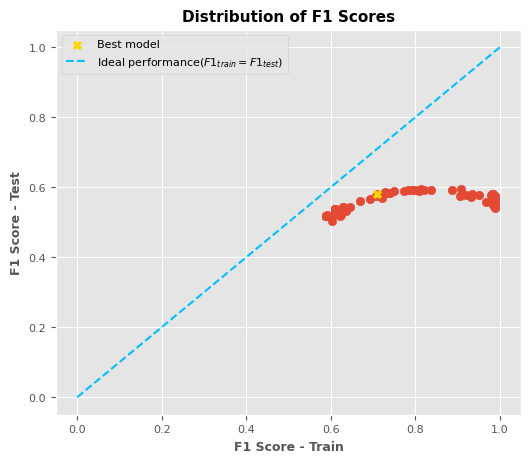


Best Model Found | Hyperparameter Tuning
 - Best F1 Score: 0.5818
 - Best Parameters:
   + C: 100
   + kernel: poly
   + gamma: auto
   + coef0: 2.0


In [30]:
SAVE_PATH = "results/seccion.json"
with open(SAVE_PATH, "r") as f:
    loaded_results = json.load(f)

train_results = [entry["train"] for entry in loaded_results]
test_results = [entry["test"] for entry in loaded_results]
grid_loaded = [entry["params"] for entry in loaded_results]

# Evaluar mejor modelo y mostrar
best_idx = plot_train_test(train_results, test_results, alpha = 0.3, beta = 0.7)
print("\n" + "="*50)
print("Best Model Found | Hyperparameter Tuning")
print("="*50)
print(f" - Best F1 Score: {test_results[best_idx]:.4f}")
print(" - Best Parameters:")
for key, value in grid_loaded[best_idx].items():
    print(f"   + {key}: {value}")
print("="*50)

Categories T, O, U have been skipped.
It have been loaded 29131 companies for training and 3589 companies for testing.
F1 Score: 0.6312


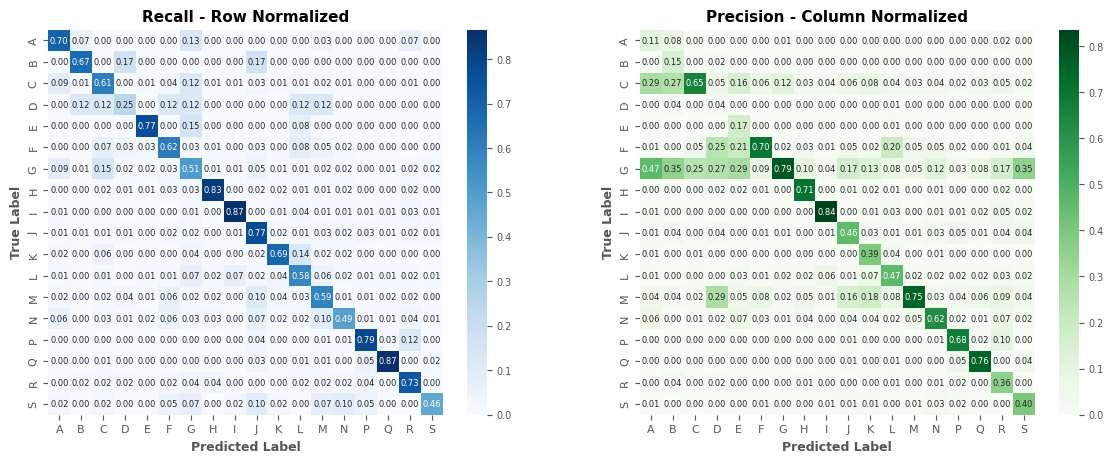

In [44]:
# Data
smote = SMOTE()
train, test = data.load_training_test_data(1, 2000, 0.1, discard = ["T", "O", "U"], 
                                           preprocess = "pooling", type = "mean")
(X_train, y_train), (X_test, y_test) = train, test
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Model
model = SVC(**grid_loaded[best_idx])
model.fit(X_train_smote, y_train_smote)

# Validation
y_pred = model.predict(X_test)
print(f"F1 Score: {f1_score(y_true = y_test, y_pred = y_pred, average = 'weighted'):.4f}")
plot_results_cm(y_test, y_pred)

<h3 style="margin-left: 1em;" id="models-2"><b>7.2. Level 2 - Division</b></h3>
<div style="margin-left: 2em;">
    <p style="text-align: justify;">
    </p>
</div>

<h4 style="margin-left: 1.5em;"><b>Flat - Hyperparameter Optimization</b></h4>

In [ ]:
grid = []
for C in [0.1, 1, 10, 100]:
    grid.append({"C": C, "kernel": "linear"})
for C in [0.1, 1, 10, 100]:
    for gamma in ["scale", "auto", 0.1, 1]:
        grid.append({"C": C, "kernel": "rbf", "gamma": gamma})
for C in [0.1, 1, 10, 100]:
    for gamma in ["scale", "auto", 0.1, 1]:
        for coef0 in [0.0, 0.5, 1.0, 2.0]:
            grid.append({"C": C, "kernel": "poly", "gamma": gamma, "coef0": coef0})

# Load previous results if the file already exists
SAVE_PATH = "results/division_flat.json"

if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        incremental_results = json.load(f)
    print(f"Loaded {len(incremental_results)} previous results from '{SAVE_PATH}'.")
else:
    incremental_results = []

smote = SMOTE()
datasets = []
for _ in tqdm(range(5), desc = "Datasets loading"):
    seed = int(random.random() * 100)
    train, test = data.load_training_test_data(2, 50, 0.2, discard = ["T", "O", "U"], seed = seed, 
                                               preprocess = "pooling", type = "mean", verbose = False)
    (X_train, y_train), (X_test, y_test) = train, test
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    datasets.append((X_train_smote, y_train_smote, X_test, y_test))

evaluated_indices = {json.dumps(entry["params"], sort_keys = True) for entry in incremental_results}
train_results = []
test_results = []

for params in tqdm(grid, desc = "Training models"):
    params_key = json.dumps(params, sort_keys=True)
    if params_key in evaluated_indices:
        continue  # Already evaluated

    f1_train_lst = []
    f1_test_lst = []
    for X_train, y_train, X_test, y_test in datasets:
        model = SVC(**params)
        model.fit(X_train, y_train)
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        train_value = f1_score(y_true=y_train, y_pred=train_predictions, average="weighted")
        test_value = f1_score(y_true=y_test, y_pred=test_predictions, average="weighted")
        f1_train_lst.append(train_value)
        f1_test_lst.append(test_value)
    train_mean = np.mean(f1_train_lst)
    test_mean = np.mean(f1_test_lst)
    incremental_results.append({
        "params": params,
        "train": train_mean,
        "test": test_mean
    })

    # Incremental saving
    with open(SAVE_PATH, "w") as f:
        json.dump(incremental_results, f, indent = 4)

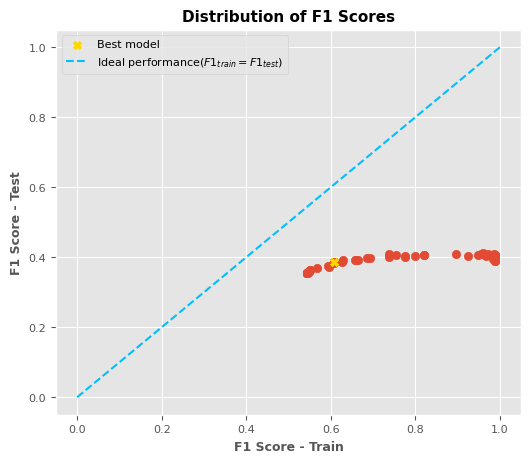


Best Model Found | Hyperparameter Tuning
 - Best F1 Score: 0.3864
 - Best F1 Train Score: 0.6065
 - Best Parameters:
   + C: 0.1
   + kernel: poly
   + gamma: auto
   + coef0: 0.0


In [27]:
SAVE_PATH = "results/division_flat.json"
# Load results
with open(SAVE_PATH, "r") as f:
    loaded_results = json.load(f)

train_results = [entry["train"] for entry in loaded_results]
test_results = [entry["test"] for entry in loaded_results]
grid_loaded = [entry["params"] for entry in loaded_results]

# Evaluar mejor modelo y mostrar
best_idx = plot_train_test(train_results, test_results, alpha = 0.3, beta = 0.7)
print("\n" + "="*50)
print("Best Model Found | Hyperparameter Tuning")
print("="*50)
print(f" - Best F1 Score: {test_results[best_idx]:.4f}")
print(f" - Best F1 Train Score: {train_results[best_idx]:.4f}")
print(" - Best Parameters:")
for key, value in grid_loaded[best_idx].items():
    print(f"   + {key}: {value}")
print("="*50)

In [12]:
# Data
smote = SMOTE()
train, test = data.load_training_test_data(2, 200, 0.2, discard = ["T", "O", "U"], 
                                           preprocess = "pooling", type = "mean")
(X_train, y_train), (X_test, y_test) = train, test
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Model
model = SVC(**grid_loaded[best_idx])
model.fit(X_train_smote, y_train_smote)

# Validation
y_pred = model.predict(X_test)
print(f"F1 Score: {f1_score(y_true = y_test, y_pred = y_pred, average = 'weighted'):.4f}")
print(classification_report(y_true = y_test, y_pred = y_pred))

Category 51 has been skipped due to an insufficient number of samples (28 samples, at least 41 required).
Category 05 has been skipped due to an insufficient number of samples (5 samples, at least 41 required).
Category 06 has been skipped due to an insufficient number of samples (3 samples, at least 41 required).
Category 09 has been skipped due to an insufficient number of samples (6 samples, at least 41 required).
Category 07 has been skipped due to an insufficient number of samples (4 samples, at least 41 required).
Category 12 has been skipped due to an insufficient number of samples (2 samples, at least 41 required).
Categories 97, 84, 98, 99, 51, 05, 06, 09, 07, 12 have been skipped.
It has loaded 13493 companies for training and 3044 companies for testing, spanning 77 categories.
F1 Score: 0.4383
              precision    recall  f1-score   support

          01       0.13      0.32      0.19        22
          02       0.17      0.67      0.27         3
          03       0.

<h4 style="margin-left: 1.5em;"><b>Hierarchical - Hyperparameter Optimization</b></h4>

In [ ]:
grid = []
for C in [0.1, 1, 10, 100]:
    grid.append({"C": C, "kernel": "linear"})
for C in [0.1, 1, 10, 100]:
    for gamma in ["scale", "auto", 0.1, 1]:
        grid.append({"C": C, "kernel": "rbf", "gamma": gamma})
for C in [0.1, 1, 10, 100]:
    for gamma in ["scale", "auto", 0.1, 1]:
        for coef0 in [0.0, 0.5, 1.0, 2.0]:
            grid.append({"C": C, "kernel": "poly", "gamma": gamma, "coef0": coef0})

# Load previous results if the file already exists
SAVE_PATH = "results/division_hierarchical.json"

if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        incremental_results = json.load(f)
    print(f"Loaded {len(incremental_results)} previous results from '{SAVE_PATH}'.")
else:
    incremental_results = []

smote = SMOTE()
datasets = []
for _ in tqdm(range(5), desc = "Datasets loading"):
    seed = int(random.random() * 100)
    train_level_2, test = data.load_hierarchical_training_test_data((50, 1000), 0.2, ["T", "O", "U"], 
                                                                preprocess = "pooling", type = "mean",
                                                                min_amount = 7, seed = seed, verbose = False)
    datasets.append((train_level_2, test))

evaluated_indices = {json.dumps(entry["params"], sort_keys = True) for entry in incremental_results}
train_results = []
test_results = []

for params in tqdm(grid, desc = "Training models"):
    params_key = json.dumps(params, sort_keys=True)
    if params_key in evaluated_indices:
        continue  # Already evaluated

    f1_train_lst = []
    f1_test_lst = []
    for train_level_2, test in datasets:
        model = SVC(**params)
        hierarchical_model = HierarchicalClassifier(base_model = model, 
                                                    resampler = smote)
        hierarchical_model.fit(train_level_2)
        X_train, y_train = [], []
        for values in train_level_2.values():
            X_train.extend(values[0])
            y_train.extend(values[1]) 
        X_test, y_test = test
        train_predictions = hierarchical_model.predict(X_train)
        test_predictions = hierarchical_model.predict(X_test)
        train_value = f1_score(y_true = y_train, y_pred = train_predictions, average = "weighted")
        test_value = f1_score(y_true = y_test, y_pred = test_predictions, average = "weighted")
        f1_train_lst.append(train_value)
        f1_test_lst.append(test_value)
    train_mean = np.mean(f1_train_lst)
    test_mean = np.mean(f1_test_lst)
    incremental_results.append({
        "params": params,
        "train": train_mean,
        "test": test_mean
    })

    # Incremental saving
    with open(SAVE_PATH, "w") as f:
        json.dump(incremental_results, f, indent = 4)

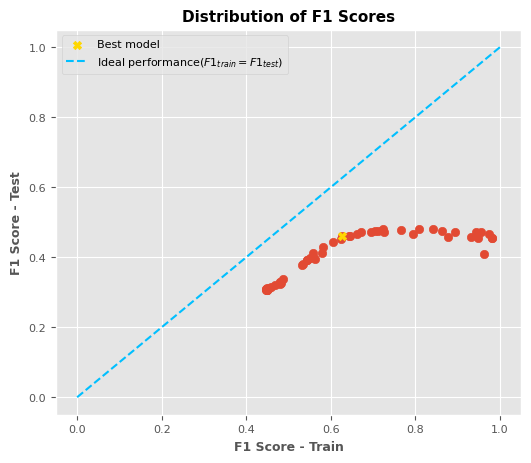


Best Model Found | Hyperparameter Tuning
 - Best F1 Test Score: 0.4593
 - Best F1 Train Score: 0.6275
 - Best Parameters:
   + C: 1
   + kernel: linear


In [9]:
SAVE_PATH = "results/division_hierarchical.json"
# Load results
with open(SAVE_PATH, "r") as f:
    loaded_results = json.load(f)

train_results = [entry["train"] for entry in loaded_results]
test_results = [entry["test"] for entry in loaded_results]
grid_loaded = [entry["params"] for entry in loaded_results]

# Evaluar mejor modelo y mostrar
best_idx = plot_train_test(train_results, test_results, alpha = 0.3, beta = 0.7)
print("\n" + "="*50)
print("Best Model Found | Hyperparameter Tuning")
print("="*50)
print(f" - Best F1 Test Score: {test_results[best_idx]:.4f}")
print(f" - Best F1 Train Score: {train_results[best_idx]:.4f}")
print(" - Best Parameters:")
for key, value in grid_loaded[best_idx].items():
    print(f"   + {key}: {value}")
print("="*50)

<h2 id="final"><b>8. Final Model</b></h2>

In [ ]:
# Model trained with the run_model_train.py script
MODEL_PATH = config["models"]["base_path"] + config["models"]["level_2"]
with open(MODEL_PATH,"rb") as file:
    hierarchical_model = pickle.load(file)

TEST_PATH = config["models"]["base_path"] + config["models"]["test_data"]
with open(TEST_PATH,"rb") as file:
    test, test_df = pickle.load(file)

In [3]:
# Validation
X_test, y_test = test
y_pred = hierarchical_model.predict(X_test)

print(f"F1 Score: {f1_score(y_true = y_test, y_pred = y_pred, average = "weighted"):.4f}")

F1 Score: 0.5608


<h3 style="margin-left: 1em;" id="final-analysis"><b>8.1. Model Analysis</b></h3>

<h4 style="margin-left: 1.5em;"><b>Analysis Level 1</b></h4>

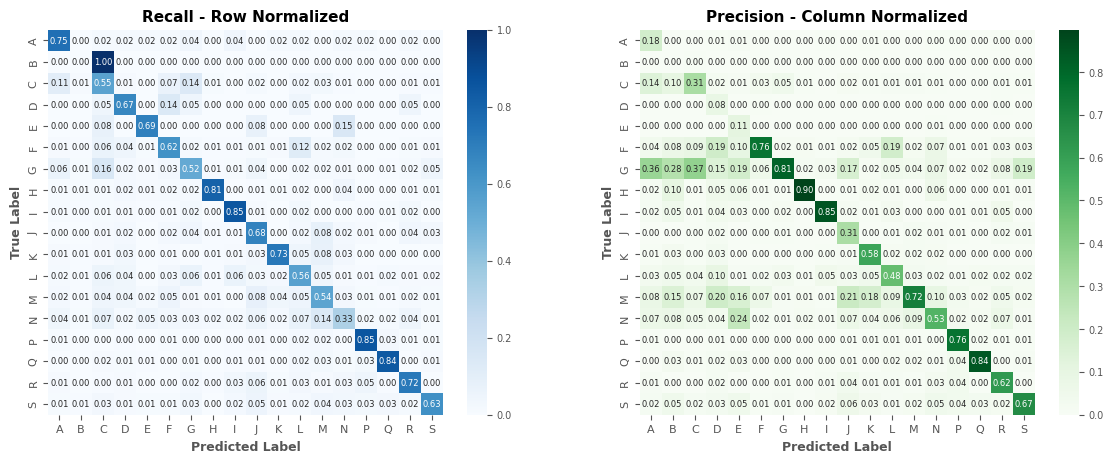

In [102]:
y_test_level_1 = [data._get_cnae_data(label, level = 1) for label in y_test]
y_pred_level_1 = [data._get_cnae_data(label, level = 1) for label in y_pred]

plot_results_cm(y_test_level_1, y_pred_level_1)

<h4 style="margin-left: 1.5em;"><b>Analysis Level 2</b></h4>

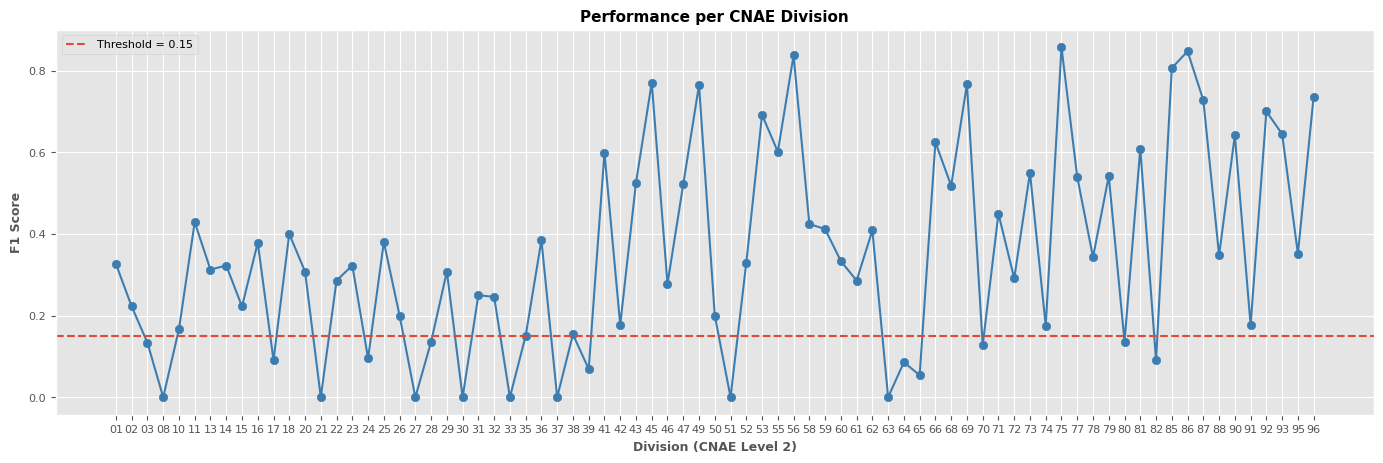

In [28]:
THRESHOLD = 0.15

labels = np.unique(y_test)
values = f1_score(y_true = y_test, y_pred = y_pred, average = None)

fig, ax = plt.subplots(1, 1, figsize =(17, 5))
ax.plot(labels, values, c = "#3C7DB1")
ax.scatter(labels, values, c = "#3C7DB1")
ax.axhline(y = THRESHOLD, linestyle="--", label=f"Threshold = {THRESHOLD}")
ax.set_ylabel("F1 Score", fontweight = "bold", fontsize=9)
ax.set_xlabel("Division (CNAE Level 2)", fontweight = "bold", fontsize=9)
ax.set_title("Performance per CNAE Division", fontweight = "bold", fontsize=11)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.legend(loc = "upper left", fontsize = 8)
plt.show()

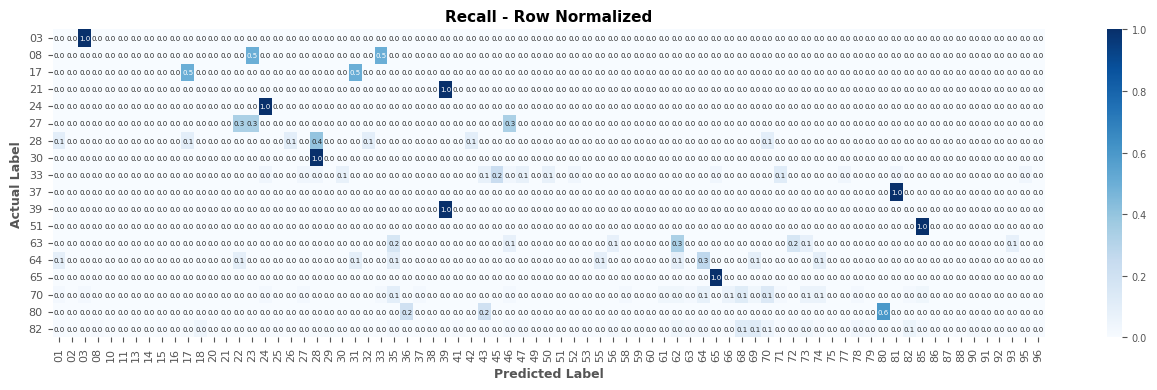

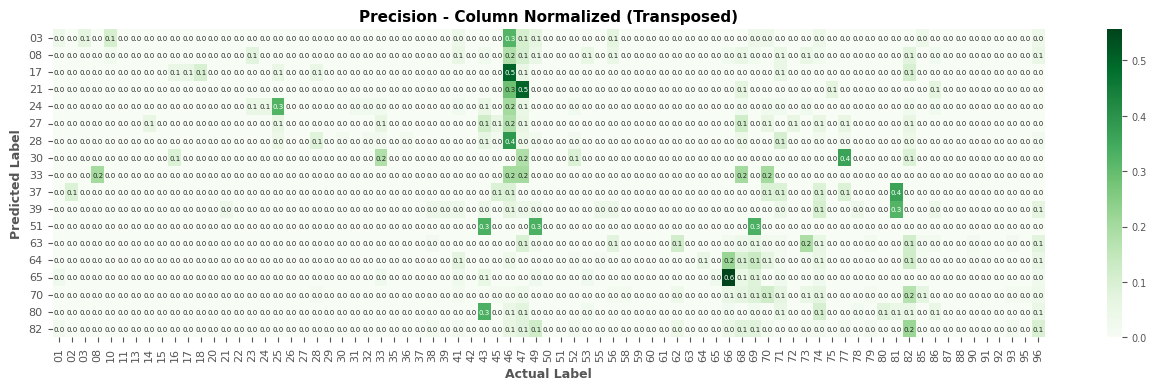

In [29]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
filtered_idx = [idx for idx, value in enumerate(values) if value < THRESHOLD]

row_filtered_cm = cm[filtered_idx]
x_labels = np.unique(y_test)
y_labels = [x_labels[idx] for idx in filtered_idx]

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
row_normalized = row_filtered_cm.astype("float") / row_filtered_cm.sum(axis = 1, keepdims = True)
sns.heatmap(row_normalized, annot = True, fmt = ".1f", cmap = "Blues", cbar = True,
                ax = ax, xticklabels = x_labels, yticklabels = y_labels, 
                annot_kws = {"size": 5})
ax.set_title("Recall - Row Normalized", fontweight ='bold', fontsize=11)
ax.set_xlabel("Predicted Label", fontweight ='bold', fontsize=9)
ax.set_ylabel("Actual Label", fontweight ='bold', fontsize=9)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.collections[0].colorbar.ax.tick_params(labelsize=7)
plt.show()

column_filtered_cm = cm[:, filtered_idx]
# x_labels, y_labels = y_labels, x_labels

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
col_normalized = column_filtered_cm.astype("float") / column_filtered_cm.sum(axis = 0, keepdims = True)
sns.heatmap(col_normalized.T, annot = True, fmt = ".1f", cmap = "Greens", cbar = True,
                ax = ax, xticklabels = x_labels, yticklabels = y_labels, 
                annot_kws = {"size": 5})
ax.set_title("Precision - Column Normalized (Transposed)", fontweight ='bold', fontsize=11)
ax.set_xlabel("Actual Label", fontweight ='bold', fontsize=9)
ax.set_ylabel("Predicted Label", fontweight ='bold', fontsize=9)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.collections[0].colorbar.ax.tick_params(labelsize=7)
plt.show()

<h3 style="margin-left: 1em;" id="final-cualitative"><b>8.2. Cualitative Error Analysis</b></h3>

<div style="margin: 1em;">
    <ul>
        <li><b>Web content ambiguity</b>. Cases in which the website text does not provide enough information or is compatible with multiple CNAE divisions. <br> <i>Example: a company that is only registered as “extractive industry” but on its website it describes that it is dedicated to extraction and sale.</i></li>
        <li><b>Non-representative web content</b>. Situations in which the web content does not reflect the real activity of the company, either because the domain has been abandoned, sold or replaced by generic content, advertising or belonging to another entity. The model, when processing text that does not correspond to the original company, makes an incorrect prediction, although consistent with the available content.<br> <i>Example: a company registered as “hospitality” whose website now displays ads from a hosting provider, and the model classifies it as a service provider.</i></li>
        <li><b>CNAE coding errors in SABI</b>. Cases in which there is a discrepancy between the registered CNAE classification and the actual activity described on the website. It is considered that the model prediction is correct and that the error is in the database. <br> <i>Example: a company dedicated to holiday accommodation according to its website, but registered as an agricultural company in SABI.</i></li>
        <li><b>Match with secondary codes</b>. Occurs when the model prediction does not coincide with the main SABI CNAE code, but does coincide with one of the secondary codes assigned to the company. This suggests that the model has correctly captured a relevant dimension of the business activity.<br> <i>Example: a company classified as “legal activities” with a secondary code in “consulting”, which is the one predicted by the model.</i></li>
        <li><b>Model error</b>. Cases where both the web content and the SABI classification clearly point to a particular category, but the model makes an erroneous prediction without apparent justification. <br><i>Example: a company described as a “logistics and transport company”, correctly registered as such, but classified by the model in an unrelated sector.</i></li>
        <li><b>Partially coherent prediction</b>. Cases in which the predicted class does not exactly match the main CNAE code registered in SABI, but reasonably reflects part of the company’s actual activity, as described on its website. The prediction may be considered acceptable when there is a functional overlap between categories or when both activities fall within a related service domain.<br> <i>Example: a company registered under “sewage and wastewater services”, whose website also mentions industrial cleaning services, and the model classifies it under “cleaning services”.</i></li>
    </ul>
</div>

In [35]:
test_df["actual"] = y_test
test_df["predicted"] = y_pred
test_df["right"] = (test_df["actual"] == test_df["predicted"])
test_df = test_df.drop(5675)
random_sample = test_df[test_df["right"] == False].groupby('label_1', 
                                                           group_keys=False).sample(n = 2, 
                                                                                    random_state = 2201)
random_sample[["name", "url", "primary_cnae", "secondary_cnae", "actual", "predicted"]]

,name,url,primary_cnae,secondary_cnae,actual,predicted
6172,PLANTACIONES DE CESPED SL.,http://www.todotepes.com/,0161,[0129],01,43
6191,FUENTE DULCE SL,https://www.fuentedulce.com/es/,0126,[0119],01,55
6214,ARIDS MANLLEU SA,https://www.aridsmanlleu.com/,0812,[],08,33
6215,ARIDS JAUME COLOMER SL,https://www.aridsjaumecolomer.com/,0812,[],08,23
1457,"BERDIEL MAQUINARIA OBRA PUBLICA, SOCIEDAD LIMI...",https://berdielmaquinaria.es/,3312,[4532],33,28
1630,CONFECCIONES AMALIO RUBIO SL,https://www.confeccionesamaliorubio.com/,1419,[],14,13
1345,TERRAL INDUSTRIAS DEL MUEBLE S.L.,http://www.terral.es/,3519,[3109],35,31
1328,ALUMINIOS FERRAGUT SL,http://www.aluminiosferragut.es/,3519,[2442],35,93
6148,DESCIEGUES Y LIMPIEZAS NAVARRA SL,https://descieguesnavarra.com/,3700,[],37,81
6151,TC TORELLO SA,http://www.tctorello.com/,3811,[],38,63


In [2]:
errors_type = {
    1: "Web content ambiguity",
    2: "Non-representative web content",
    3: "CNAE coding errors in SABI",
    4: "Match with secondary codes",
    5: "Model error",
    6: "Partially coherent prediction"
}
model_prediction = {
    0: "Invalid",
    1: "Valid"
}

color_mapping = {
    "Valid": "#66c2a5",
    "Invalid": "#fc8d62"
}

errors = [(1, 1, "Dedicada a la producción de cesped (01), pero también a la instalación y mantenimiento de cesped, y construcción de campos de golf (43)."),
          (2, 1, "Dedicada al alojamiento vacacional, casa rural, (55), pero registrada como agricultura (01)."),
          (5, 0, "Dedicada a la extracción y venta de áridos (08)"),
          (1, 1, "Dedicada a la extracción y venta de áridos (08), pero clasificada por el modelo como fabricación de productos minerales no metálicos (23)"),
          (5, 0, "Dedicada a la venta y mantenimiento de maquinaria industrial (33-45), pero clasificada por el modelo como fabricación de maquinaria industrial (28)"),
          (6, 1, "Dedicada a la confección manual de prendas (13), pero clasificada por el modelo como fabricación de prendas/industría textil (14)."),
          (4, 1, "Coincidencia con el código secundario, no analizado con detalle."),
          (2, 1, "Registrada como suministro de energía y otros servicios (35), pero su contenido web está vacio y el único texto disponible es 'RD3 Eventos Deportivos' (93)."),
          (6, 1, "Dedicada y registrada al tratamiento de aguas residuales (37), pero también se dedica, y el modelo predice, a proveer servicios de limpieza (81)."),
          (2, 1, "Dominio abandonado, contiene publicidad sobre el proveedor de servicios de hosting (63)."),
          (3, 1, "Registrada como construcción especializada (43), pero se dedica a la instalación y mantenimiento de servicios de vigilancia (80)."),
          (5, 0, "Registrada como constructora/promociones inmobiliarias (41), pero se dedica a la gestión inmobiliaria (68) y el modelo la clasifica como aseguradora (65)."),
          (2, 0, "El contenido web no refleja ninguna actividad empresarial, completamente vacio."),
          (6, 1, "Resgistrada como comercio al por menor (47), pero su contenido web también refleja que se dedica a la producción de productos alimentarios (10)"),
          (5, 0, "Dedicada al transporte de mercancias por carretera (49), pero clasificada por el modelo como actividades administrativas (82)."),
          (5, 0, "Dedicada al transporte de mercancias por carretera (49), pero clasificada por el modelo como comercio al por mayor (46)"),
          (3, 1, "Registrada como hostelería en la rama de comida y bebida (56), pero se dedica y el modelo clasifica como servicio de alojamiento vacacional (55)."),
          (2, 1, "Dominio abandonado, contiene publicidad sobre el proveedor de servicios de hosting (63)."),
          (3, 0, "Registrada como proveedor de servicios informáticos (63), pero se dedica a la consultoría sobre el sector de la energía (70) y el modelo la clasifica como suministrador de energía (35)."),
          (4, 1, "Coincidencia con el código secundario, no analizado con detalle."),
          (6, 1, "Registrada como gestora de activos financieros y seguros (66), pero es una aseguradora (65)."),
          (5, 0, "Registrada como gestora de activos financieros y seguros (66), pero el modelo la clasifica como aseguradora (65)."),
          (2, 0, "El contenido web no refleja ninguna actividad empresarial, completamente vacio."),
          (6, 1, "Registrada como industría alimentaria (10) y comercio al por menor (47), pero el modelo la clasifica como comercio al por mayor (46)."),
          (6, 1, "Registrada como servicios técnicos de ingeniería (71) y clasificada por el modelo como actividades de consultoría informática (62)."),
          (5, 0, "Registrada como asesoría contable y jurídica (69), pero clasificada por el modelo como proveedor de servicios de hosting (63)."),
          (5, 0, "Registrada como actividades de oficina (82), pero se dedica la distribución e instalación de gas (35) y el modelo la clasifica como editora de libros (58)."),
          (4, 1, "Coincidencia con el código secundario, no analizado con detalle."),
          (2, 0, "El contenido web no refleja ninguna actividad empresarial, completamente vacio."),
          (6, 1, "Registrada como educación (85), pero clasificada por el modelo como actividades de cuidado de niños (88)."),
          (6, 1, "Registrada como actividades sanitarias (86), pero se dedica, y el modelo predice, al transporte de pacientes (49)."),
          (4, 1, "Coincidencia con el código secundario, no analizado con detalle."),
          (6, 1, "Registrada como proveedora de servicios de espectaculos (90), pero también se dedica, y el modelo clasifica, como alquiler de artículos (77)."),
          (5, 0, "Registrada como artistas y proveedores de espectaculos (90), pero clasificada por el modelo como servicios de hosting (63)."),
          (3, 1, "Registrada como servicios personales (96), pero ofrece un servicio de reservas de alojamiento vacacional (79)."),
          (6, 1, "Registrada como servicios personales (96), pero su actividad principal es el alojamiento vacacional (55).")
         ]

In [6]:
errors_df = pd.DataFrame(errors, columns=["error_type", "is_valid", "description"])
errors_df["error_label"] = errors_df["error_type"].map(errors_type)
errors_df["prediction_validity"] = errors_df["is_valid"].map(model_prediction)

In [9]:
validity_counts = errors_df["prediction_validity"].value_counts()
total = validity_counts.sum()
print(f"{'Prediction Validity':<20} | {'Cases':<10} | {'Proportion':<10}")
print("-" * 46)
for label in validity_counts.index:
    if label in color_mapping:
        count = validity_counts[label]
        proportion = count / total
        print(f"{label:<20} | {count:^10,} | {proportion:^10.2%}")

Prediction Validity  | Cases      | Proportion
----------------------------------------------
Valid                |     23     |   63.89%  
Invalid              |     13     |   36.11%  


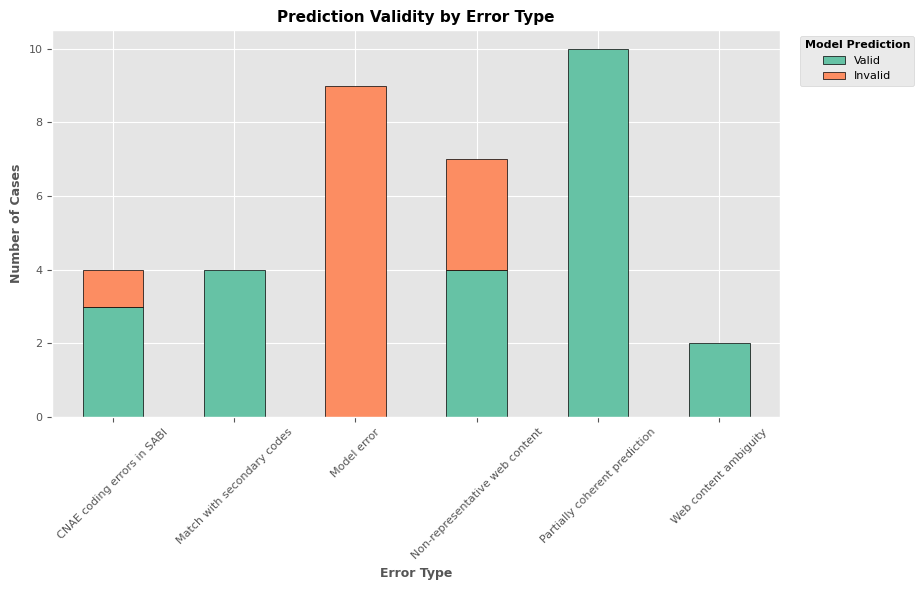

In [11]:
stacked_counts = errors_df.groupby(["error_label", "prediction_validity"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(8, 6))
stacked_counts = stacked_counts[[col for col in color_mapping if col in stacked_counts.columns]]
stacked_counts.plot(
    kind      = "bar",
    stacked   = True,
    ax        = ax,
    color     = [color_mapping[col] for col in stacked_counts.columns],
    edgecolor = "black",
    legend    = False
)
ax.set_title("Prediction Validity by Error Type", fontweight='bold', fontsize=11)
ax.set_xlabel("Error Type", fontweight="bold", fontsize=9)
ax.set_ylabel("Number of Cases", fontweight="bold", fontsize=9)
ax.tick_params(axis="x", labelsize=8, rotation=45)
ax.tick_params(axis="y", labelsize=8)

plt.tight_layout()
legend = plt.legend(title="Model Prediction", loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=8)
legend.get_title().set_fontsize(8)
legend.get_title().set_fontweight("bold")
plt.show()

<h2 id="references"><b>9. References</b></h2>
<div style="margin: 1em;">
    <p id="ref-1">
        <b>[1]</b> <b>N. Reimers and I. Gurevych</b>, <i>Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks</i>, arXiv, 2019.  
        <br>
        &emsp; &ensp;[Online]. Available:  
        <a href="https://arxiv.org/abs/1908.10084" target="_blank">
            https://arxiv.org/abs/1908.10084
        </a>
    </p>
    <p id="ref-2">
        <b>[2]</b> <b>A. Akbik, T.Bergmann, and R. Vollgraf</b>, <i>Pooled Contextualized Embeddings for Named Entity Recognition</i>, Association for Computational Linguistics, 2019.  
        <br>
        &emsp; &ensp;[Online]. Available:  
        <a href="https://aclanthology.org/N19-1078/" target="_blank">
           https://aclanthology.org/N19-1078/
        </a>
    </p>
    <p id="ref-3">
        <b>[3]</b> <b>Q. Chen, Z. Ling, and X. Zhu</b>, <i>Enhancing Sentence Embedding with Generalized Pooling</i>, arXiv, 2018.  
        <br>
        &emsp; &ensp;[Online]. Available:  
        <a href="https://arxiv.org/abs/1806.09828" target="_blank">
           https://arxiv.org/abs/1806.09828
        </a>
    </p>
    <p id="ref-4"> 
        <b>[4]</b> <b>Anna Glazkova</b>, <i>A Comparison of Synthetic Oversampling Methods for Multi-class Text Classification</i>, arXiv, 2020.  
        <br>
        &emsp; &ensp;[Online]. Available:  
        <a href="https://arxiv.org/abs/2008.04636" target="_blank">
            https://arxiv.org/abs/2008.04636
        </a>  
    </p>
    <p id="ref-5"> 
        <b>[5]</b> <b>Wikipedia</b>, <i>Jensen–Shannon divergence</i>  
        <br>
        &emsp; &ensp;[Online]. Available:  
        <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence" target="_blank">
            https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
        </a>  
    </p>
</div>